In [1]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import csv

import hcp_utils as hcp
import conf

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import plot_con_helper
import feature_selec_functions
import graph_comparison_helper
import importlib

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### Load data

Load functional connectivity data of all subjects

In [2]:
all_fc_data = pd.read_csv("all_fc_data.csv")
all_fc_data = all_fc_data.loc[:, ~all_fc_data.columns.str.contains('^Unnamed')] #delete un-named column

Load a list of all features (= all possible edges - 4950)

In [3]:
importlib.reload(graph_comparison_helper)
all_features_temp = all_fc_data.columns
#convert from strings to tuples
all_features = graph_comparison_helper.conv_to_tuple(all_features_temp)

#all_features

Models' features - load models' results

In [4]:
importlib.reload(plot_con_helper)

#Paths to results 
PATH = conf.RESULTS_DIR

#Plot results of all 3 tasks
#dfs = ['df_DD_l1FixedFisher_02', 'df_F_l1FixedFisher_02', 'df_PicVocab_Unil1FixedFisher_02']


#dfs = ['DDisc_AUC_40K_l1notFixed', 'Flanker_AgeAdj_l1notFixed']
#dfs = ['Flanker_AgeAdj_l1notFixed', 'PicVocab_AgeAdj__l1notFixed']
dfs = ['DDisc_AUC_40K', 'PicVocab_AgeAdj_l1Fixed']

#'PicVocab_AgeAdj_l1Fixed'

df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    #df = df[['node1', 'node2', 'R']] #For reg analysis
    df = df[['node1', 'node2', 'beta', 'rel_edges']] #For models
    df.columns = ['node1', 'node2', 'beta', 'rel_edges']
    df_arranged[dfs[i]] = df
    

Parcels list - load list of parcel names

In [5]:
#path to parcellation labels 
path_label = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order_info.txt'

with open(path_label, 'r') as f:
    lines = f.readlines()

In [6]:
#list of parcels
list_parcel = []
for i in range(0, len(lines), 2): #only even rows
    list_parcel.append(lines[i][10:-1])
#len(list_parcel)
#list_parcel

### Create dfs for comparison

In [7]:
#selected features of each model
DD_features_temp = list(df_arranged[dfs[0]].rel_edges)
F_features_temp = list(df_arranged[dfs[1]].rel_edges)
#convert from strings to tuples
DD_features = graph_comparison_helper.conv_to_tuple(DD_features_temp)
F_features = graph_comparison_helper.conv_to_tuple(F_features_temp)

In [8]:
#betas of each model
DD_beta = list(df_arranged[dfs[0]].beta)
F_beta = list(df_arranged[dfs[1]].beta)

In [9]:
importlib.reload(graph_comparison_helper)
df_DD = graph_comparison_helper.arrange_df(all_features, DD_features, DD_beta)
df_F = graph_comparison_helper.arrange_df(all_features, F_features, F_beta)

In [10]:
#validation
df_F.loc[df_F['all_features'] == (1,26)]

,all_features,model_features_logic,beta
123,"(1, 26)",0,NaN


Add parcel names

In [11]:
importlib.reload(graph_comparison_helper)
node_names = graph_comparison_helper.get_node_names(all_features, list_parcel)
df_DD = graph_comparison_helper.add_node_names(df_DD, node_names)
df_F = graph_comparison_helper.add_node_names(df_F, node_names)

Add net names

In [12]:
#add net names and beta_abs
plot_con_helper.add_col(df_DD)
plot_con_helper.add_col(df_F)

,all_features,model_features_logic,beta,node1,node2,beta_abs,node1_nets,node2_nets,node1_hm_nets,node2_hm_nets
0,"(0, 1)",0,NaN,LH_Vis_1,LH_Vis_2,NaN,Vis,Vis,LH_Vis,LH_Vis
1,"(0, 2)",0,NaN,LH_Vis_1,LH_Vis_3,NaN,Vis,Vis,LH_Vis,LH_Vis
2,"(0, 3)",0,NaN,LH_Vis_1,LH_Vis_4,NaN,Vis,Vis,LH_Vis,LH_Vis
3,"(0, 4)",0,NaN,LH_Vis_1,LH_Vis_5,NaN,Vis,Vis,LH_Vis,LH_Vis
4,"(0, 5)",0,NaN,LH_Vis_1,LH_Vis_6,NaN,Vis,Vis,LH_Vis,LH_Vis
...,...,...,...,...,...,...,...,...,...,...
4945,"(96, 98)",0,NaN,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_1,NaN,Default,Default,RH_Default,RH_Default
4946,"(96, 99)",0,NaN,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_2,NaN,Default,Default,RH_Default,RH_Default
4947,"(97, 98)",0,NaN,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_1,NaN,Default,Default,RH_Default,RH_Default
4948,"(97, 99)",0,NaN,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_2,NaN,Default,Default,RH_Default,RH_Default


Sorted DFs - only for observation, don't include in the running of the code

In [13]:
#df_F =  df_F.sort_values(by=['beta'], ascending=False,  ignore_index=True)
#df_F.head(10)

In [14]:
#df_DD =  df_DD.sort_values(by=['beta'], ascending=False,  ignore_index=True)
#df_DD.head(10)

In [15]:
#validation
df_F.loc[df_F['all_features'] == (1,26)]

,all_features,model_features_logic,beta,node1,node2,beta_abs,node1_nets,node2_nets,node1_hm_nets,node2_hm_nets
123,"(1, 26)",0,NaN,LH_Vis_2,LH_SalVentAttn_PFCl_1,NaN,Vis,SalVentAttn,LH_Vis,LH_SalVentAttn


In [16]:
df_F

,all_features,model_features_logic,beta,node1,node2,beta_abs,node1_nets,node2_nets,node1_hm_nets,node2_hm_nets
0,"(0, 1)",0,NaN,LH_Vis_1,LH_Vis_2,NaN,Vis,Vis,LH_Vis,LH_Vis
1,"(0, 2)",0,NaN,LH_Vis_1,LH_Vis_3,NaN,Vis,Vis,LH_Vis,LH_Vis
2,"(0, 3)",0,NaN,LH_Vis_1,LH_Vis_4,NaN,Vis,Vis,LH_Vis,LH_Vis
3,"(0, 4)",0,NaN,LH_Vis_1,LH_Vis_5,NaN,Vis,Vis,LH_Vis,LH_Vis
4,"(0, 5)",0,NaN,LH_Vis_1,LH_Vis_6,NaN,Vis,Vis,LH_Vis,LH_Vis
...,...,...,...,...,...,...,...,...,...,...
4945,"(96, 98)",0,NaN,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_1,NaN,Default,Default,RH_Default,RH_Default
4946,"(96, 99)",0,NaN,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_2,NaN,Default,Default,RH_Default,RH_Default
4947,"(97, 98)",0,NaN,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_1,NaN,Default,Default,RH_Default,RH_Default
4948,"(97, 99)",0,NaN,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_2,NaN,Default,Default,RH_Default,RH_Default


In [17]:
df_DD[(df_DD["node1_nets"] == "Cont") & (df_DD["node2_nets"] == "DorsAttn") & (np.isnan(df_DD["beta"])  == False)]

,all_features,model_features_logic,beta,node1,node2,beta_abs,node1_nets,node2_nets,node1_hm_nets,node2_hm_nets
2905,"(35, 71)",1,0.014766,LH_Cont_pCun_1,RH_DorsAttn_PrCv_1,0.014766,Cont,DorsAttn,LH_Cont,RH_DorsAttn
2968,"(36, 71)",1,0.010051,LH_Cont_Cing_1,RH_DorsAttn_PrCv_1,0.010051,Cont,DorsAttn,LH_Cont,RH_DorsAttn


Sum the frequent beta's sign across pairs of nets

In [18]:
df_DD[(df_DD["beta"]) == 0]

,all_features,model_features_logic,beta,node1,node2,beta_abs,node1_nets,node2_nets,node1_hm_nets,node2_hm_nets
55,"(0, 56)",1,-0.0,LH_Vis_1,RH_Vis_7,0.0,Vis,Vis,LH_Vis,RH_Vis
114,"(1, 17)",1,-0.0,LH_Vis_2,LH_DorsAttn_Post_3,0.0,Vis,DorsAttn,LH_Vis,LH_DorsAttn
147,"(1, 50)",1,0.0,LH_Vis_2,RH_Vis_1,0.0,Vis,Vis,LH_Vis,RH_Vis
148,"(1, 51)",1,0.0,LH_Vis_2,RH_Vis_2,0.0,Vis,Vis,LH_Vis,RH_Vis
153,"(1, 56)",1,-0.0,LH_Vis_2,RH_Vis_7,0.0,Vis,Vis,LH_Vis,RH_Vis
...,...,...,...,...,...,...,...,...,...,...
4446,"(67, 92)",1,-0.0,RH_DorsAttn_Post_2,RH_Default_Temp_3,0.0,DorsAttn,Default,RH_DorsAttn,RH_Default
4494,"(69, 79)",1,-0.0,RH_DorsAttn_Post_4,RH_Limbic_TempPole_1,0.0,DorsAttn,Limbic,RH_DorsAttn,RH_Limbic
4523,"(70, 79)",1,-0.0,RH_DorsAttn_Post_5,RH_Limbic_TempPole_1,0.0,DorsAttn,Limbic,RH_DorsAttn,RH_Limbic
4543,"(70, 99)",1,-0.0,RH_DorsAttn_Post_5,RH_Default_pCunPCC_2,0.0,DorsAttn,Default,RH_DorsAttn,RH_Default


In [19]:
len(df_DD.node2_hm_nets.unique())

14

In [20]:
def count_beta(x):
    """
    Add the following columns to the df:
    num_exists_beta = number of existing features in the model
    percent_pos = percent of positive betas
    percent_neg = percent of negative betas
    percent_mode = percent of edges with the mode beta sign (positive/negative)
    num_beta_zeros = how many of the existing features equal to 0 (doesn't count as pos or neg)
    """
    d = {}
    d["num_exists_beta"] = (x["beta"]).count()
    d["percent_pos"] = 0
    d["percent_neg"] = 0
    d["percent_mode"] = 0
    d["num_beta_zeros"] = (x["beta"] == 0).sum()
    if d["num_exists_beta"] > 0 and (d["num_exists_beta"] - d["num_beta_zeros"]) > 0: #only if the existing features are more than 0 and not all of them are equal to 0
        d["percent_pos"] = 100*(x["beta"] > 0).sum()/(d["num_exists_beta"] - d["num_beta_zeros"]) #don't include the betas that equal to 0
        d["percent_neg"] = 100*(x["beta"] < 0).sum()/(d["num_exists_beta"] -d["num_beta_zeros"])
        if d["percent_pos"] > d["percent_neg"]:
            d["percent_mode"] = d["percent_pos"]
        else:
            d["percent_mode"] = d["percent_neg"]
            
    return pd.Series(d,index=d.keys())

In [21]:
#net names
val1 = "node1_nets"
val2 = "node2_nets"

In [22]:
#group by net names
df_F_agg = df_F.groupby([val1, val2]).apply(count_beta).reset_index()
df_DD_agg = df_DD.groupby([val1, val2]).apply(count_beta).reset_index()

#group by hm_net names
#df_F_agg = df_F.groupby(["node1_hm_nets", "node2_hm_nets"]).apply(count_beta).reset_index()
#df_DD_agg = df_DD.groupby(["node1_hm_nets", "node2_hm_nets"]).apply(count_beta).reset_index()

In [23]:
df_DD_agg

,node1_nets,node2_nets,num_exists_beta,percent_pos,percent_neg,percent_mode,num_beta_zeros
0,Cont,Cont,6.0,100.000000,0.000000,100.000000,0.0
1,Cont,Default,8.0,100.000000,0.000000,100.000000,0.0
2,Cont,DorsAttn,2.0,100.000000,0.000000,100.000000,0.0
3,Cont,Limbic,1.0,0.000000,100.000000,100.000000,0.0
4,Cont,SalVentAttn,2.0,100.000000,0.000000,100.000000,0.0
5,Cont,SomMot,0.0,0.000000,0.000000,0.000000,0.0
6,Cont,Vis,1.0,100.000000,0.000000,100.000000,0.0
7,Default,Cont,0.0,0.000000,0.000000,0.000000,0.0
8,Default,Default,13.0,23.076923,76.923077,76.923077,0.0
9,Default,DorsAttn,13.0,0.000000,100.000000,100.000000,8.0


Homogeneity validation

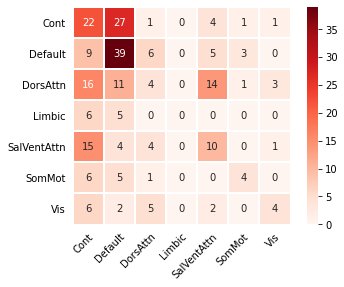

In [25]:
importlib.reload(graph_comparison_helper)
graph_comparison_helper.create_heatmap_modeBeta(df = df_F_agg, val_col = "num_exists_beta", val1 = val1, val2 = val2)

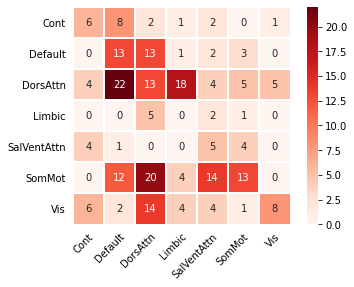

In [26]:
importlib.reload(graph_comparison_helper)
graph_comparison_helper.create_heatmap_modeBeta(df = df_DD_agg, val_col = "num_exists_beta", val1 = val1, val2 = val2)

In [ ]:
df_F_agg.num_exists_beta.quantile(q=0.9)

In [27]:
#compute the difference between the betas mean and the betas_abs mean
def get_betas_diff(df):
    df["betas_diff"] = abs(df["beta"] - df["beta_abs"])

In [28]:
df_DD_aggBeta = df_DD.groupby([val1, val2]).mean().reset_index()
get_betas_diff(df_DD_aggBeta)
df_DD_aggBeta

,node1_nets,node2_nets,model_features_logic,beta,beta_abs,betas_diff
0,Cont,Cont,0.076923,0.020239,0.020239,0.000000
1,Cont,Default,0.041026,0.007914,0.007914,0.000000
2,Cont,DorsAttn,0.071429,0.012409,0.012409,0.000000
3,Cont,Limbic,0.125000,-0.003804,0.003804,0.007609
4,Cont,SalVentAttn,0.100000,0.024818,0.024818,0.000000
5,Cont,SomMot,0.000000,NaN,NaN,NaN
6,Cont,Vis,0.031250,0.015509,0.015509,0.000000
7,Default,Cont,0.000000,NaN,NaN,NaN
8,Default,Default,0.047101,-0.005354,0.014333,0.019687
9,Default,DorsAttn,0.142857,-0.001301,0.001301,0.002602


In [29]:
df_F_aggBeta = df_F.groupby([val1, val2]).mean().reset_index()
get_betas_diff(df_F_aggBeta)
df_F_aggBeta

,node1_nets,node2_nets,model_features_logic,beta,beta_abs,betas_diff
0,Cont,Cont,0.282051,0.664666,0.674547,0.009881
1,Cont,Default,0.138462,0.019655,0.742947,0.723293
2,Cont,DorsAttn,0.035714,0.834992,0.834992,0.000000
3,Cont,Limbic,0.000000,NaN,NaN,NaN
4,Cont,SalVentAttn,0.200000,0.697508,0.697508,0.000000
5,Cont,SomMot,0.031250,-0.461628,0.461628,0.923255
6,Cont,Vis,0.031250,-0.718287,0.718287,1.436574
7,Default,Cont,0.076923,-0.796055,0.796055,1.592111
8,Default,Default,0.141304,0.151377,0.792534,0.641158
9,Default,DorsAttn,0.065934,-0.229904,0.229904,0.459808


<AxesSubplot:xlabel='beta_abs'>

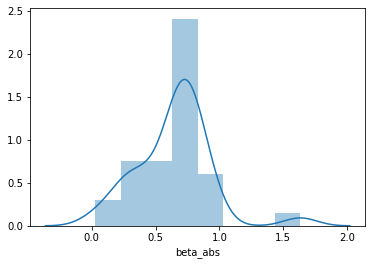

In [30]:
sns.distplot(df_F_aggBeta.beta_abs)

<AxesSubplot:xlabel='beta_abs'>

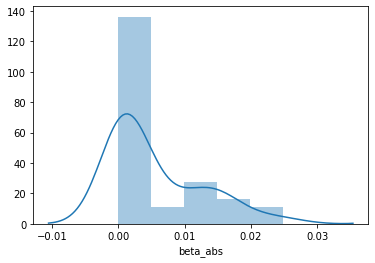

In [31]:
sns.distplot(df_DD_aggBeta.beta_abs)

In [ ]:
#df_F_aggBeta =  df_F_aggBeta.sort_values(by=['beta_abs'], ascending=False,  ignore_index=True)
#df_F_aggBeta.head(20)

In [ ]:
#df_DD_aggBeta =  df_DD_aggBeta.sort_values(by=['beta_abs'], ascending=False,  ignore_index=True)
#df_DD_aggBeta.head(20)

In [32]:
#Make sure the pairs of nodes are equal in both data frames
s1 = df_DD_aggBeta[val1]
s2 = df_F_aggBeta[val1]
assert s1.compare(s2).shape[0] == 0, "Column of nodes 1 don't match in both dfs!"

In [33]:
s1 = df_DD_aggBeta[val2]
s2 = df_F_aggBeta[val2]
assert s1.compare(s2).shape[0] == 0, "Column of nodes 2 don't match in both dfs!"

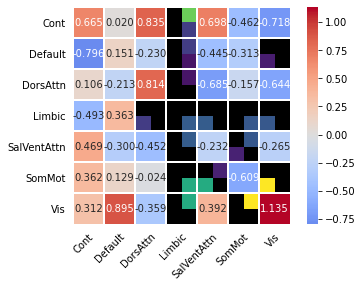

In [40]:
importlib.reload(graph_comparison_helper)
graph_comparison_helper.create_heatmap_modeBeta(df = df_F_aggBeta, val_col = "beta", val1 = val1, val2 = val2)

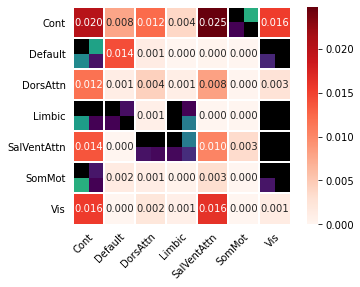

In [39]:
importlib.reload(graph_comparison_helper)
graph_comparison_helper.create_heatmap_modeBeta(df = df_DD_aggBeta, val_col = "beta_abs", val1 = val1, val2 = val2)

In [ ]:
x, y = df_DD_aggBeta.beta_abs, df_F_aggBeta.beta_abs
#x, y = df_DD_agg.percent_mode, df_DD_aggBeta.betas_diff

from scipy import stats
stats.spearmanr(x, y, nan_policy = "omit")

In [ ]:
def spearman_test(x,y):
    r_score = stats.spearmanr(x, y, nan_policy = "omit")[0]
    p_value = stats.spearmanr(x, y, nan_policy = "omit")[1]

    return round(r_score, 3), round(p_value, 4)

In [ ]:
#F, DD -> color: #4a47a3
#F/DD, PV -> color: #FF3659
#F -> color: #eb5e0b
#D -> color: #5eaaa8

x, y = df_DD_aggBeta.beta_abs, df_F_aggBeta.beta_abs 
#x, y = df_F_agg.percent_mode, df_F_aggBeta.betas_diff 

fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)

sns.set_style("ticks", {'axes.grid' : False})
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.regplot(x, y, ax=ax, color = "#4a47a3")
sns.despine()

plt.text(max(x)-max(x)*0.1, min(y), spearman_test(x,y), fontsize=12)
plt.xlabel('Abs betas of DD model')
plt.ylabel('Abs betas of F model')

#plt.xlabel('Pecent mode of PV model')
#plt.ylabel('Diff between betas and betas_abs of PV model')

plt.show()

In [ ]:
from mlxtend.evaluate import permutation_test

#x, y = df_DD_aggBeta.beta, df_F_aggBeta.beta

print('Observed pearson R: %.2f' % stats.spearmanr(x, y, nan_policy = "omit")[0])


p_value = permutation_test(x, y,
                           method='approximate', num_rounds=10000,
                           func=lambda x, y: np.corrcoef(x, y)[1][0],
                           seed=0)
print('P value: %.4f' % p_value)